In [1]:

!pip install transformers torch tensorflow scikit-learn pandas numpy matplotlib

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import re
import matplotlib.pyplot as plt



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")


df = pd.read_csv('urdu_sarcastic_dataset.csv')
print(f"Dataset: {df.shape}")

Using device: cuda
GPU: Tesla T4
Dataset: (20060, 8)


In [4]:
print("CLEANING DATA...")

def preprocess_urdu_text(text):
    if pd.isna(text) or text == '':
        return ""

    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_text'] = df['urdu_text'].apply(preprocess_urdu_text)
df = df.dropna(subset=['clean_text', 'is_sarcastic'])
df = df[df['clean_text'].str.strip() != '']
df['is_sarcastic'] = df['is_sarcastic'].astype(int)


sarcastic_data = df[df['is_sarcastic'] == 1]
non_sarcastic_data = df[df['is_sarcastic'] == 0]

samples_per_class = 6450

sarcastic_samples = sarcastic_data.sample(n=min(samples_per_class, len(sarcastic_data)), random_state=42)
non_sarcastic_samples = non_sarcastic_data.sample(n=min(samples_per_class, len(non_sarcastic_data)), random_state=42)

balanced_df = pd.concat([sarcastic_samples, non_sarcastic_samples], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset: {balanced_df.shape}")
print(f"Balanced labels: {balanced_df['is_sarcastic'].value_counts().to_dict()}")

X = balanced_df['clean_text']
y = balanced_df['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape[0]}")
print(f"Testing set: {X_test.shape[0]}")
print(f"Training labels: {y_train.value_counts().to_dict()}")
print(f"Testing labels: {y_test.value_counts().to_dict()}")

CLEANING DATA...
Balanced dataset: (12900, 9)
Balanced labels: {0: 6450, 1: 6450}
Training set: 10320
Testing set: 2580
Training labels: {0: 5160, 1: 5160}
Testing labels: {0: 1290, 1: 1290}


In [5]:
class UrduSarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Dataset class created")

Dataset class created


In [6]:
class mBERTBiLSTM_MHA(nn.Module):
    def __init__(self, n_classes=2, lstm_units=32, n_heads=2, dropout=0.3):
        super(mBERTBiLSTM_MHA, self).__init__()


        self.bert = AutoModel.from_pretrained('bert-base-multilingual-cased')


        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=lstm_units,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )


        self.attention = nn.MultiheadAttention(
            embed_dim=lstm_units * 2,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )


        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_units * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, n_classes)
        )

    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state


        lstm_out, _ = self.bilstm(sequence_output)


        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)


        pooled = attn_out.mean(dim=1)


        return self.classifier(pooled)

print("Paper's mBERT-BiLSTM-MHA model")

Paper's mBERT-BiLSTM-MHA model


In [7]:
print("INITIALIZING MODEL...")


tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model = mBERTBiLSTM_MHA(
    n_classes=2,
    lstm_units=32,
    n_heads=2,
    dropout=0.3
)
model = model.to(device)

print(f"Model loaded on: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


train_dataset = UrduSarcasmDataset(X_train, y_train, tokenizer)
test_dataset = UrduSarcasmDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Data loaders ready: {len(train_loader)} train batches, {len(test_loader)} test batches")

INITIALIZING MODEL...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Model loaded on: cuda
Total parameters: 178,079,682
Data loaders ready: 323 train batches, 81 test batches


In [8]:
from torch.optim import AdamW

print("STARTING TRAINING (Paper's Method)...")

def train_paper_model():
    model.train()
    optimizer = AdamW(model.parameters(), lr=2e-5)  # Paper: 2e-05
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(15):
        total_loss = 0
        model.train()

        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()


            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)


            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')


        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        avg_loss = total_loss / len(train_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(accuracy)

        print(f'\nEpoch {epoch+1}/15')
        print(f'   Training Loss: {avg_loss:.4f}')
        print(f'   Validation Accuracy: {accuracy:.4f}')
        print('-' * 50)

        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_paper_model.pth')
            print(f' NEW BEST MODEL! Accuracy: {best_accuracy:.4f}')

    return all_preds, all_labels, best_accuracy, train_losses, val_accuracies

# Start training
predictions, true_labels, best_accuracy, train_losses, val_accuracies = train_paper_model()

STARTING TRAINING (Paper's Method)...
Epoch 1, Batch 0, Loss: 0.6897
Epoch 1, Batch 50, Loss: 0.6294
Epoch 1, Batch 100, Loss: 0.5489
Epoch 1, Batch 150, Loss: 0.6796
Epoch 1, Batch 200, Loss: 0.5715
Epoch 1, Batch 250, Loss: 0.6292
Epoch 1, Batch 300, Loss: 0.6826

Epoch 1/15
   Training Loss: 0.6030
   Validation Accuracy: 0.7783
--------------------------------------------------
 NEW BEST MODEL! Accuracy: 0.7783
Epoch 2, Batch 0, Loss: 0.5604
Epoch 2, Batch 50, Loss: 0.4110
Epoch 2, Batch 100, Loss: 0.6185
Epoch 2, Batch 150, Loss: 0.4728
Epoch 2, Batch 200, Loss: 0.4613
Epoch 2, Batch 250, Loss: 0.3884
Epoch 2, Batch 300, Loss: 0.7093

Epoch 2/15
   Training Loss: 0.5265
   Validation Accuracy: 0.7899
--------------------------------------------------
 NEW BEST MODEL! Accuracy: 0.7899
Epoch 3, Batch 0, Loss: 0.5502
Epoch 3, Batch 50, Loss: 0.6157
Epoch 3, Batch 100, Loss: 0.5833
Epoch 3, Batch 150, Loss: 0.4958
Epoch 3, Batch 200, Loss: 0.5523
Epoch 3, Batch 250, Loss: 0.8062
Epoch

In [12]:
print("=" * 60)

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print("RESULTS (mBERT-BiLSTM-MHA):")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")


print(f"\nDetailed Classification Report:")
print(classification_report(true_labels, predictions, target_names=['Non-Sarcastic', 'Sarcastic']))

# Save final model
torch.save(model.state_dict(), 'best_paper_model.pth')
print("BEST Model saved as 'best_paper_model.pth'")

RESULTS (mBERT-BiLSTM-MHA):
   Accuracy:  0.7988
   Precision: 0.8009
   Recall:    0.7988
   F1-Score:  0.7985

Detailed Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.83      0.76      0.79      1290
    Sarcastic       0.78      0.84      0.81      1290

     accuracy                           0.80      2580
    macro avg       0.80      0.80      0.80      2580
 weighted avg       0.80      0.80      0.80      2580

BEST Model saved as 'best_paper_model.pth'


PLOTTING TRAINING RESULTS...


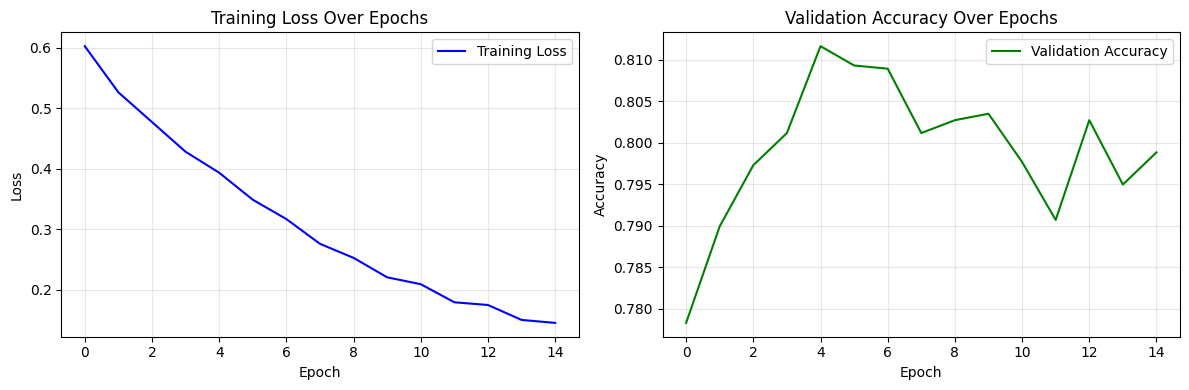

In [13]:
# CELL 8: Plot Results
print("PLOTTING TRAINING RESULTS...")

plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
print("SAVING BEST MODEL")

best_model = mBERTBiLSTM_MHA(n_classes=2, lstm_units=32, n_heads=2, dropout=0.3)
best_model.load_state_dict(torch.load('best_paper_model.pth'))
best_model = best_model.to(device)
best_model.eval()

torch.save({
    'model_state_dict': best_model.state_dict(),
    'tokenizer': tokenizer,
    'model_architecture': best_model,
    'accuracy': best_accuracy,
    'training_losses': train_losses,
    'val_accuracies': val_accuracies,
}, 'complete_urdu_sarcasm_model.pth')

print("BEST Model saved as 'complete_urdu_sarcasm_model.pth'")

SAVING BEST MODEL
BEST Model saved as 'complete_urdu_sarcasm_model.pth'


In [23]:
print("LOADING MODEL WITH SECURITY FIX...")

import torch
from transformers import BertTokenizerFast
torch.serialization.add_safe_globals([BertTokenizerFast])


checkpoint = torch.load('complete_urdu_sarcasm_model.pth', weights_only=False)

model = checkpoint['model_architecture']
tokenizer = checkpoint['tokenizer']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model loaded successfully! Accuracy: {checkpoint['accuracy']:.4f}")

LOADING MODEL WITH SECURITY FIX...
Model loaded successfully! Accuracy: 0.8116


In [24]:
def predict_urdu_sarcasm(text, model, tokenizer, device, max_len=128):
    """
    Predict if Urdu text is sarcastic
    Returns: label, confidence, raw_prediction
    """
    model.eval()
    text = str(text).strip()
    if text == "":
        return "Invalid text", 0.0, -1

    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        prediction = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][prediction].item()

    label = "SARCASMIC" if prediction == 1 else "NON-SARCASMIC"
    return label, confidence, prediction

print("Prediction function ready!")

Prediction function ready!


In [30]:
def check_urdu_sarcasm(text, model, tokenizer, device, max_len=128):
    """Check if a single Urdu text is sarcastic"""
    model.eval()

    encoding = tokenizer(
        text,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, prediction = torch.max(probabilities, 1)

        result = "Sarcastic" if prediction.item() == 1 else "Not Sarcastic"

    return result, confidence.item(), prediction.item()

print("URDU SARCASM DETECTION:")

sample_texts = [
    "واہ کیا بات ہے ہر چیز کی قیمتیں آسمان کو چھو رہی ہیں",
    "بہت اچھا موسم ہے بارش ہو رہی ہے",
    "ٹریفک بہت ہموار ہے کوئی رکاوٹ نہیں ہے",
    "میں نے آج کام مکمل کر لیا ہے"
]

for i, text in enumerate(sample_texts, 1):
    label, confidence, pred = check_urdu_sarcasm(text, model, tokenizer, device)

    print(f"{i}. {text}")
    print(f"   Result: {label}")
    print(f"   Confidence: {confidence:.1%}")
    print()

URDU SARCASM DETECTION:
1. واہ کیا بات ہے ہر چیز کی قیمتیں آسمان کو چھو رہی ہیں
   Result: Sarcastic
   Confidence: 99.2%

2. بہت اچھا موسم ہے بارش ہو رہی ہے
   Result: Not Sarcastic
   Confidence: 99.5%

3. ٹریفک بہت ہموار ہے کوئی رکاوٹ نہیں ہے
   Result: Not Sarcastic
   Confidence: 99.4%

4. میں نے آج کام مکمل کر لیا ہے
   Result: Not Sarcastic
   Confidence: 91.5%

